In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu117
torchvision version: 0.14.0+cu117


In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
from going_modular import data_setup, engine
from torch import nn
from torchvision import transforms
from torchinfo import summary


In [5]:
torch.cuda.empty_cache()

In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get data

Before we can start to use **transfer learning**, we will set up the dataset into DataLoaders

In [7]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
path = "S:/galaxydata/"
data_path = Path(path)
image_path = data_path / "data"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")


S:\galaxydata\data directory exists.


Excellent!

Now we've got the same dataset we've been using previously, a series of galaxy images in standard image classification format.

Let's now create paths to our training and test directories.

In [8]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Datasets and DataLoaders

Since we've downloaded the `going_modular` directory, we can use the data_setup.py to prepare and setup our DataLoaders.

But since we'll be using a pretrained model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html), there's a specific transform we need to prepare our images first.

In [9]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [10]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x206f6c042e0>,
 ['Disk, Edge-on, Boxy Bulge',
  'Disk, Edge-on, No Bulge',
  'Disk, Edge-on, Rounded Bulge',
  'Disk, Face-on, Loose Spiral',
  'Disk, Face-on, Medium Spiral',
  'Disk, Face-on, No Spiral',
  'Disk, Face-on, Tight Spiral',
  'Smooth, Cigar shaped',
  'Smooth, Completely round',
  'Smooth, in-between round'])

### Creating a transform for `torchvision.models` 



In [11]:
# Get a set of pretrained model weights
weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1 # .DEFAULT = best available weights from pretraining on ImageNet
weights

ViT_B_16_Weights.IMAGENET1K_V1

And now to access the transforms assosciated with our `weights`, we can use the `transforms()` method.

This is essentially saying "get the data transforms that were used to train the `ViT_B_16_Weights` on ImageNet".

In [12]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Notice how `auto_transforms` is very similar to `manual_transforms`, the only difference is that `auto_transforms` came with the model architecture we chose, where as we had to create `manual_transforms` by hand.

The benefit of automatically creating a transform through `weights.transforms()` is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

We can use `auto_transforms` to create DataLoaders with `create_dataloaders()` just as before.

In [13]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x206f6c041f0>,
 ['Disk, Edge-on, Boxy Bulge',
  'Disk, Edge-on, No Bulge',
  'Disk, Edge-on, Rounded Bulge',
  'Disk, Face-on, Loose Spiral',
  'Disk, Face-on, Medium Spiral',
  'Disk, Face-on, No Spiral',
  'Disk, Face-on, Tight Spiral',
  'Smooth, Cigar shaped',
  'Smooth, Completely round',
  'Smooth, in-between round'])

## Getting a pretrained model


Here we use the base Vision Transformer Architecture from the <i><b>An Image is Worth 16x16 Words</i></b> paper

In [14]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
model = torchvision.models.vit_b_16(weights = weights, progress = False).to(device)

model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [15]:
#Prints ImageNet classification categories (1000 classes)
weights.meta['categories']

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python',
 'Indian cobr

### Getting a summary of our model with `torchinfo.summary()`

We use torchinfo to learn more about the model we are using:
To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model.
 * `col_names` - the various information columns we'd like to see about our model. 
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [16]:
# Print a summary using torchinfo (uncomment for actual output)
input_size = (32, 3, 224, 224)
summary(model=model, 
        input_size= input_size, 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 1000] 768        True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592    True
├─Encoder (encoder)                                          [32, 197, 768] [32, 197, 768] 151,296    True
│    └─Dropout (dropout)                                     [32, 197, 768] [32, 197, 768] --         --
│    └─Sequential (layers)                                   [32, 197, 768] [32, 197, 768] --         True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_

### Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

Let's freeze all of the layers/parameters in the `features` section

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.


In [17]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.encoder.parameters():
    param.requires_grad = False

Nice!

Now we update the output layer of the model to our current classes instead of the ImageNet classes

In [18]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.heads = torch.nn.Sequential(
    torch.nn.Linear(in_features=768, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

#Change output classes to Astronomy classes
weights.meta['categories'] = class_names

In [19]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size= input_size, # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 10]   768        Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592    True
├─Encoder (encoder)                                          [32, 197, 768] [32, 197, 768] 151,296    False
│    └─Dropout (dropout)                                     [32, 197, 768] [32, 197, 768] --         --
│    └─Sequential (layers)                                   [32, 197, 768] [32, 197, 768] --         False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBloc

Here, we see that <i>Trainable</i> is set to False except for the final layer of the model

In [20]:
import torchinfo 
torchinfo.summary(model, input_size= input_size)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [32, 10]                  768
├─Conv2d: 1-1                                 [32, 768, 14, 14]         590,592
├─Encoder: 1-2                                [32, 197, 768]            151,296
│    └─Dropout: 2-1                           [32, 197, 768]            --
│    └─Sequential: 2-2                        [32, 197, 768]            --
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-4                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-5                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-6                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-7 

## Train model

Because we're still working with multi-class classification, we'll use `nn.CrossEntropyLoss()` for the loss function and `torch.optim.Adam()` as our optimizer with `lr=0.001`.


In [21]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

Wonderful! 

To train our model, we can use `train()` function we defined in the [05. PyTorch Going Modular section 04](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them).

The `train()` function is in the [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py) script inside the [`going_modular` directory](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular). 

Let's see how long it takes to train our model for 50 epochs.

> **Note:** We're only going to be training the parameters `classifier` here as all of the other parameters in our model have been frozen.

In [22]:
# Set the random seeds
torch.manual_seed(50)
torch.cuda.manual_seed(50)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0786 | train_acc: 0.2224 | test_loss: 1.9186 | test_acc: 0.3054
Epoch: 2 | train_loss: 1.8273 | train_acc: 0.3274 | test_loss: 1.8067 | test_acc: 0.3666
Epoch: 3 | train_loss: 1.6962 | train_acc: 0.3857 | test_loss: 1.6361 | test_acc: 0.4013
Epoch: 4 | train_loss: 1.5545 | train_acc: 0.4405 | test_loss: 1.5921 | test_acc: 0.4759
Epoch: 5 | train_loss: 1.4886 | train_acc: 0.4644 | test_loss: 1.4871 | test_acc: 0.4719
Epoch: 6 | train_loss: 1.4398 | train_acc: 0.4819 | test_loss: 1.5218 | test_acc: 0.4741
Epoch: 7 | train_loss: 1.3761 | train_acc: 0.5009 | test_loss: 1.3966 | test_acc: 0.5178
Epoch: 8 | train_loss: 1.3372 | train_acc: 0.5240 | test_loss: 1.4113 | test_acc: 0.5155
Epoch: 9 | train_loss: 1.2643 | train_acc: 0.5550 | test_loss: 1.4156 | test_acc: 0.5003
Epoch: 10 | train_loss: 1.2581 | train_acc: 0.5652 | test_loss: 1.3561 | test_acc: 0.5146
Epoch: 11 | train_loss: 1.2220 | train_acc: 0.5655 | test_loss: 1.4419 | test_acc: 0.4979
Epoch: 12 | train_l

## Evaluate model by plotting loss curves

Let's plot it's loss curves to see what the training looks like over time. 

We can plot the loss curves using the `plot_loss_curves` function from the `helper_functions.py`script 

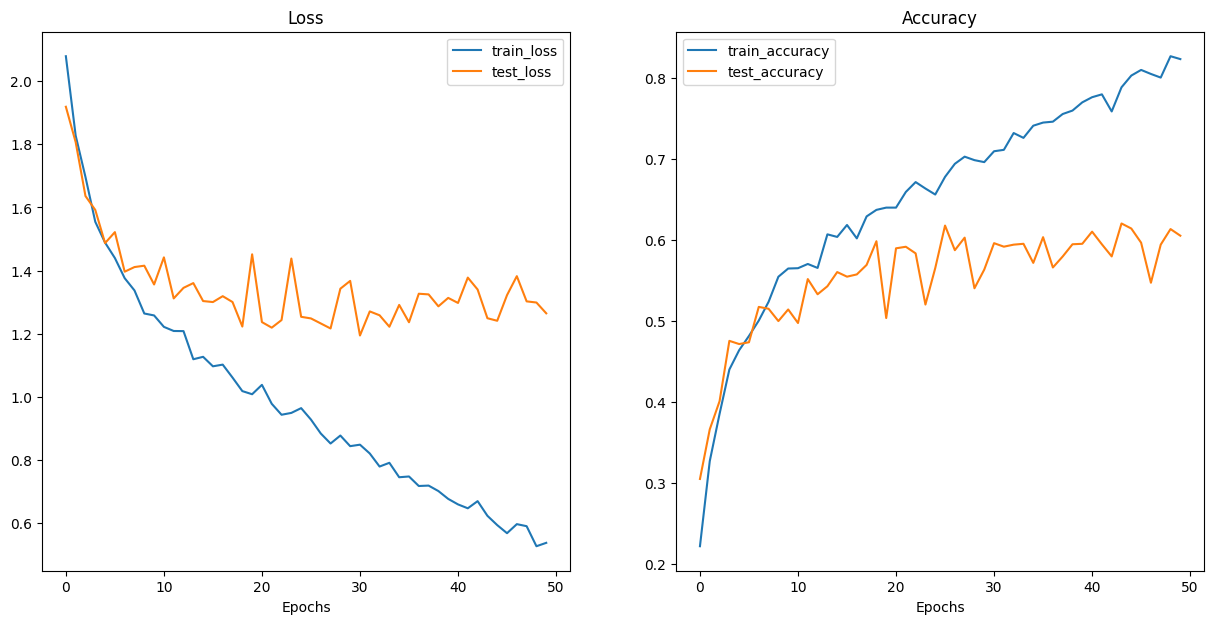

In [23]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
from helper_functions import plot_loss_curves

plot_loss_curves(results)